# Evaluate combinatorial variants

Using the GB1 landscape as a test case. See [here](https://elifesciences.org/articles/16965). Downloaded from [FLIP](https://github.com/J-SNACKKB/FLIP/blob/main/splits/gb1/four_mutations_full_data.csv.zip)

In [1]:
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
from aide_predict.utils.common import get_supported_tools

In [3]:
get_supported_tools()

/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


HMMWrapper: AVAILABLE
ESM2LikelihoodWrapper: AVAILABLE
MSATransformerLikelihoodWrapper: AVAILABLE
EVMutationWrapper: AVAILABLE
SaProtLikelihoodWrapper: AVAILABLE
ESM2Embedding: AVAILABLE
OneHotAlignedEmbedding: AVAILABLE
OneHotProteinEmbedding: AVAILABLE
MSATransformerEmbedding: AVAILABLE
SaProtEmbedding: AVAILABLE



'HMMWrapper: AVAILABLE\nESM2LikelihoodWrapper: AVAILABLE\nMSATransformerLikelihoodWrapper: AVAILABLE\nEVMutationWrapper: AVAILABLE\nSaProtLikelihoodWrapper: AVAILABLE\nESM2Embedding: AVAILABLE\nOneHotAlignedEmbedding: AVAILABLE\nOneHotProteinEmbedding: AVAILABLE\nMSATransformerEmbedding: AVAILABLE\nSaProtEmbedding: AVAILABLE\n'

## Load the dataset

In [4]:
import os
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sklearn.utils.validation import check_is_fitted
from sklearn.ensemble import RandomForestRegressor

# Protein specific data structures
from aide_predict.utils.data_structures import ProteinSequence, ProteinSequences, ProteinSequencesOnFile

# Stick with Sprot zero shot and embedding for this notebook.
from aide_predict.bespoke_models import ESM2Embedding, ESM2LikelihoodWrapper, OneHotProteinEmbedding

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from aide_predict.utils.plotting import plot_protein_sequence_heatmap
sns.set_style("whitegrid")
sns.set_context("talk")

In [5]:
data = pd.read_csv(os.path.join('data', 'four_mutations_full_data.csv'))[['sequence', 'Fitness', 'three_vs_rest']].dropna()

/var/folders/4b/6yg7r65x0152cnhzpgzdhmvrjcvswz/T/ipykernel_10891/3170391716.py:1: DtypeWarning: Columns (8,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join('data', 'four_mutations_full_data.csv'))[['sequence', 'Fitness', 'three_vs_rest']].dropna()


In [6]:
train_data = data[data['three_vs_rest'] == 'train']
test_data = data[data['three_vs_rest'] == 'test']

In [7]:
train_sequences = ProteinSequences([ProteinSequence(seq) for seq in train_data['sequence']])
test_sequences = ProteinSequences([ProteinSequence(seq) for seq in test_data['sequence']])

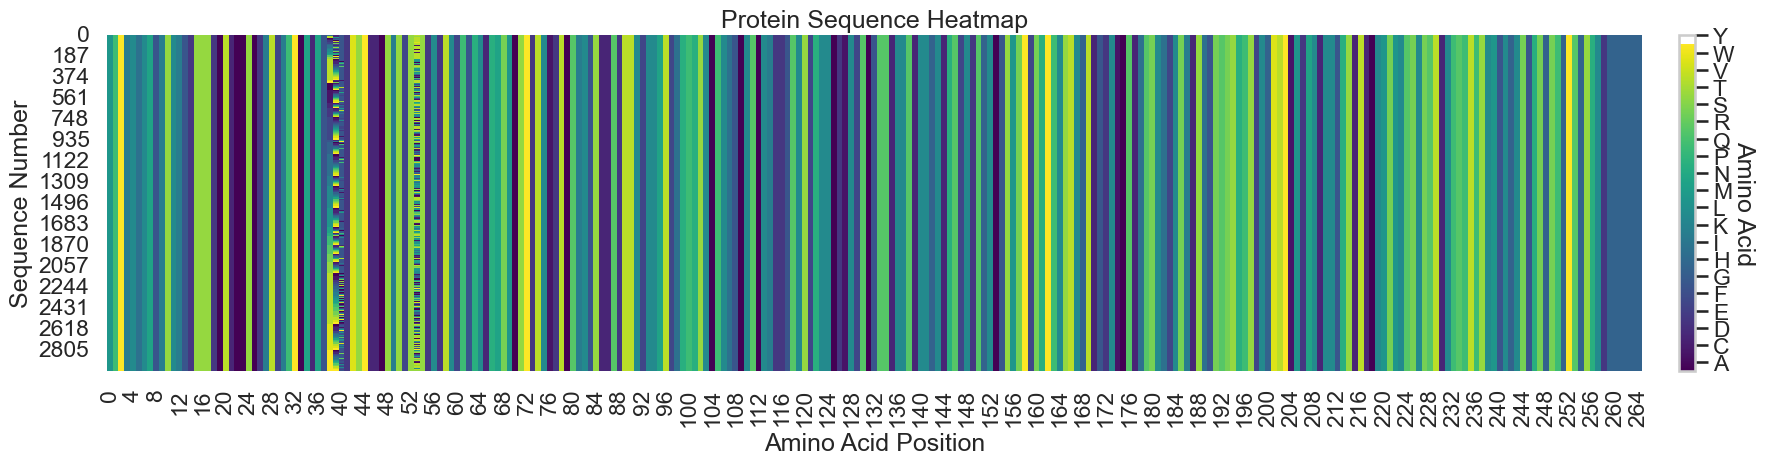

In [8]:
_ = plot_protein_sequence_heatmap(train_sequences)

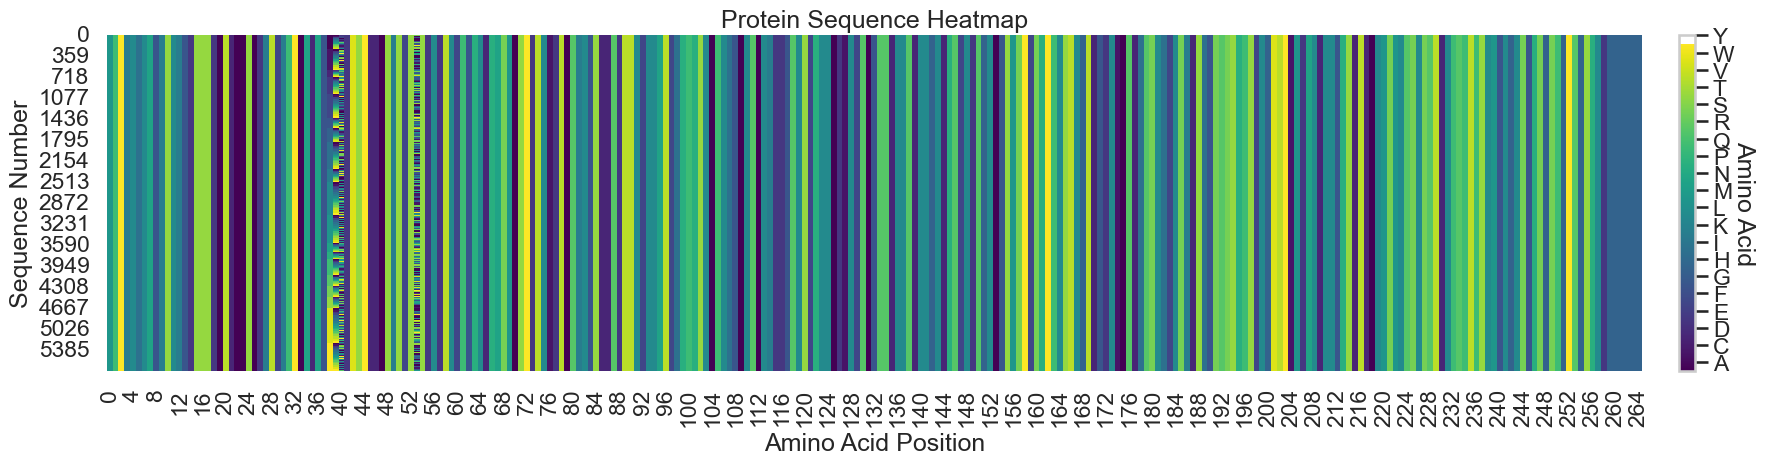

In [9]:
_ = plot_protein_sequence_heatmap(test_sequences)

## Define the wild type sequence and structure

In [10]:
wt = ProteinSequence(
    'MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTELEVLFQGPLDPNSMATYEVLCEVARKLGTDDREVVLFLLNVFIPQPTLAQLIGALRALKEEGRLTFPLLAECLFRAGRRDLLRDLLHLDPRFLERHLAGTMSYFSPYQLTVLHVDGELCARDIRSLIFLSKDTIGSRSTPQTFLHWVYCMENLDLLGPTDVDALMSMLRSLSRVDLQRQVQTLMGLHLSGPSHSQHYRHTPLEHHHHHH',
    id='wt')

In [11]:
len(wt) == test_sequences.width

True

## Start with zero shot prediction using ESM2

In [12]:
model = ESM2LikelihoodWrapper(
    pool=True, # we want the scores to be averaged over the whole protein
    metadata_folder='esm2', # required for the API, but MSATransformer does not use it
    wt=wt,
    marginal_method='wildtype_marginal',
    device="mps"
)
model.fit([]) #ESM2 requires no fitting sequences

This model class did not implement check_metadata. If the model requires anything other than raw sequences to be fit, this is unexpected.


ESM2LikelihoodWrapper(device='mps', marginal_method='wildtype_marginal',
                      metadata_folder='esm2',
                      wt=ProteinSequence(id='wt', seq='MQYKLILNGKTLKGETTTEA...'))

In [13]:
esm_predictions = model.predict(test_sequences)

/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Computing log likelihoods: 100%|██████████| 1/1 [00:00<00:00,  1.87sequence/s]


In [14]:
test_data['esm2 likelihood'] = esm_predictions

/var/folders/4b/6yg7r65x0152cnhzpgzdhmvrjcvswz/T/ipykernel_10891/3015071451.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['esm2 likelihood'] = esm_predictions


In [15]:
test_data

,sequence,Fitness,three_vs_rest,esm2 likelihood
28187,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAAAEWTYD...,1.611610,test,-3.336921
28200,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAACEWTYD...,3.741833,test,-3.631914
28225,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAAEEWTYD...,0.000000,test,-3.808031
28228,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAAFEWTYD...,1.081518,test,-3.379137
28231,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAAFEWTYD...,2.087250,test,-3.560137
...,...,...,...,...
149271,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYSEWTYD...,0.368577,test,-4.036638
149311,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYVEWTYD...,1.044870,test,-3.757311
149312,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYVEWTYD...,0.002253,test,-3.964759
149352,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYYEWTYD...,0.026282,test,-4.279274


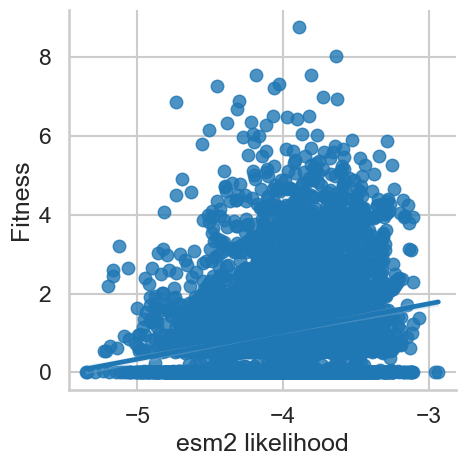

In [16]:
sns.lmplot(x='esm2 likelihood', y='Fitness', data=test_data)

## Instead, train a supervised model on training set

Let's restrain our embeddings to just the four positions explored, and not mean over those positions.
If your dataset were not fixed length, you'd have to pool.

In [17]:
variable_positions = train_sequences.mutated_positions
variable_positions

[38, 39, 40, 53]

In [18]:
embedder = ESM2Embedding(
    positions=variable_positions,
    metadata_folder='esm2_emb',
    device="mps",
    pool=False,
    flatten=True
)
X_train = embedder.fit_transform(train_sequences)
X_test = embedder.transform(test_sequences)

This model class did not implement check_metadata. If the model requires anything other than raw sequences to be fit, this is unexpected.


In [19]:
regressor = RandomForestRegressor()
regressor.fit(X_train, train_data['Fitness'].values)

RandomForestRegressor()

In [20]:
supervised_predictions = regressor.predict(X_test)

In [21]:
test_data['rf_esm2'] = supervised_predictions

/var/folders/4b/6yg7r65x0152cnhzpgzdhmvrjcvswz/T/ipykernel_10891/207309929.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rf_esm2'] = supervised_predictions


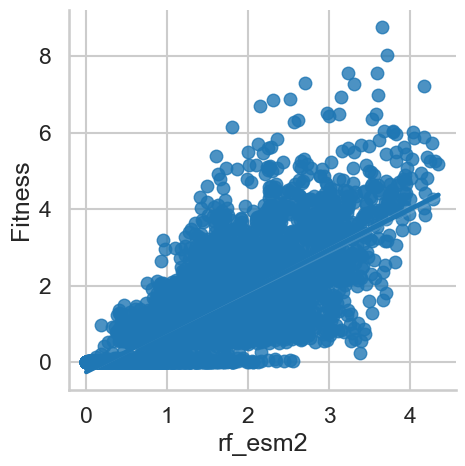

In [23]:
sns.lmplot(x='rf_esm2', y='Fitness', data=test_data)

## Construct a more complicated pipeline

[Hsu et al.](https://www.nature.com/articles/s41587-021-01146-5) suggested that zero shot scores as input to a supervised model can improve performance. AIDE makes mixing and matching differenct components into pipleines extemely easy, because we can leverage sklearn pipeline API.

1. Embed sequences with ESM2, only keep positions with mutations from embeddings
2. Add to the embeddings a zero shot score from MSA transformer
3. Standard scale embeddings and run PCA
4. Train a Random Forest on the PCA components

In [24]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from aide_predict.bespoke_models import MSATransformerLikelihoodWrapper

In [25]:
# Zero shot model
zero_shot_model = MSATransformerLikelihoodWrapper(
    pool=True,
    metadata_folder='esm2',
    wt=wt,
    marginal_method='wildtype_marginal',
    device="mps"
)
msa = ProteinSequencesOnFile(os.path.join('..', 'tests', 'data', 'gb1.a2m'))
zero_shot_model.fit(msa)

# Embedder
embedder = ESM2Embedding(
    positions=variable_positions,
    metadata_folder='esm2_emb',
    device="mps",
    pool=False,
    flatten=True
)

# let's throw some other sklearn transformers in there
scaler = StandardScaler()
pca = PCA(n_components=10)


# put it together into a pipeline
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('zero_shot', zero_shot_model),
        ('embedding_features', Pipeline([
            ('embedder', embedder),
            ('scaler', scaler),
            # ('pca', pca)
        ]))
    ])),
    ('regressor', RandomForestRegressor())
])
pipeline


This model class did not implement check_metadata. If the model requires anything other than raw sequences to be fit, this is unexpected.
This model class did not implement check_metadata. If the model requires anything other than raw sequences to be fit, this is unexpected.


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('zero_shot',
                                                 MSATransformerLikelihoodWrapper(device='mps',
                                                                                 marginal_method='wildtype_marginal',
                                                                                 metadata_folder='esm2',
                                                                                 wt=ProteinSequence(id='wt', seq='MQYKLILNGKTLKGETTTEA...'))),
                                                ('embedding_features',
                                                 Pipeline(steps=[('embedder',
                                                                  ESM2Embedding(device='mps',
                                                                                flatten=True,
                                                                                metadata_folder='esm2_emb',
                                                                                positions=[38,
                                                                                           39,
                                                                                           40,
                                                                                           53],
                                                                                use_cache=True)),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('regressor', RandomForestRegressor())])

In [26]:
pipeline.fit(train_sequences, train_data['Fitness'].values)

Model is already fitted. Skipping
MSA batches: 17it [00:36,  2.17s/it]      | 0/1 [00:00<?, ?sequence/s]
Computing log likelihoods: 100%|██████████| 1/1 [00:36<00:00, 36.85s/sequence]
/Users/ekomp/Documents/repos/lab/aide_predict/aide_predict/bespoke_models/predictors/pretrained_transformers.py:435: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  log_likelihoods = np.array(new_log_likelihoods)


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('zero_shot',
                                                 MSATransformerLikelihoodWrapper(device='mps',
                                                                                 marginal_method='wildtype_marginal',
                                                                                 metadata_folder='esm2',
                                                                                 wt=ProteinSequence(id='wt', seq='MQYKLILNGKTLKGETTTEA...'))),
                                                ('embedding_features',
                                                 Pipeline(steps=[('embedder',
                                                                  ESM2Embedding(device='mps',
                                                                                flatten=True,
                                                                                metadata_folder='esm2_emb',
                                                                                positions=[38,
                                                                                           39,
                                                                                           40,
                                                                                           53],
                                                                                use_cache=True)),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('regressor', RandomForestRegressor())])

In [27]:
combined_predictions = pipeline.predict(test_sequences)
test_data['zs+(pca->rf'] = combined_predictions

MSA batches: 17it [00:36,  2.17s/it]      | 0/1 [00:00<?, ?sequence/s]
Computing log likelihoods: 100%|██████████| 1/1 [00:36<00:00, 36.83s/sequence]
/var/folders/4b/6yg7r65x0152cnhzpgzdhmvrjcvswz/T/ipykernel_10891/1009513732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['zs+(pca->rf'] = combined_predictions


In [28]:
test_data.corr('spearman')['Fitness']

Fitness            1.000000
esm2 likelihood    0.209062
rf_esm2            0.832780
zs+(pca->rf        0.832653
Name: Fitness, dtype: float64